In [1]:
#importing necessary libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import random
import tensorflow as tf
# Set the seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
#reading in dataset 
df = pd.read_csv('final_df.csv')
df1 = df['close']

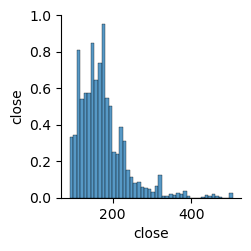

In [2]:
sns.pairplot(df)

In [3]:
df.head(100)

,close,date
0,132.045,2015-05-27
1,131.780,2015-05-28
2,130.280,2015-05-29
3,130.535,2015-06-01
4,129.960,2015-06-02
...,...,...
95,112.120,2015-10-09
96,111.600,2015-10-12
97,111.790,2015-10-13
98,110.210,2015-10-14


In [4]:
#LSTM's are sensitive to the scale of the data and because the distrbution is not Gaussian, MinMaxScaler wll be implemented 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

print(df1.shape)
print(df1)

(2456, 1)
[[0.10031269]
 [0.09967529]
 [0.09606735]
 ...
 [0.36084185]
 [0.35348166]
 [0.36440168]]


In [5]:
# splitting data into training and testing 
training_size = int(len(df1)*0.65)
test_size = len(df1) -training_size
train_data, test_data = df1[0:training_size],df1[training_size:len(df1),:1]

print(training_size, test_size)
#print(train_data, test_data)

1596 860


In [6]:
# convert an array of values into a dataset matrix 
def create_dataset(dataset,time_step =1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i +time_step,0])
    return np.array(dataX),np.array(dataY)

In [7]:
#Reshape into X = t, t+1, t+2,t+3 and Y= t+4 
time_step = 100
X_train, y_train= create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

In [8]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape

((1495, 100), (1495,), (759, 100), (759,))

In [9]:
# reshape the data 
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

print(X_train.shape), print(X_test.shape)

(1495, 100, 1)
(759, 100, 1)


(None, None)

# LSTM1


In [10]:
# importing libraries 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import LSTM


In [11]:
#Building the model ,LSTM uses sigmoid and tanh as activation functions 
# Added in one more layers than the RNN 
stack_model = Sequential()
stack_model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
stack_model.add(LSTM(50,return_sequences=True))
stack_model.add(LSTM(50,return_sequences=True))
stack_model.add(LSTM(50))
stack_model.add(Dense(1))
stack_model.compile(loss = "mean_squared_error", optimizer = "adam",metrics = ['mae','mse'])

stack_model.summary()

c:\Users\andre\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Initialize an empty dictionary to store the results
epochs_list = [ 50]
batch_size_list = [64]

results_lstm = {}

# Loop over epochs and batch sizes
for epochs in epochs_list:
    for batch_size in batch_size_list:
        print(f"Training with epochs={epochs} and batch_size={batch_size}")
        
        # Fit the model with the current hyperparameters
        history = stack_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                                  epochs=epochs, batch_size=batch_size, verbose=1)
        
        # Get the validation loss from the training history
        val_loss = history.history['val_loss'][-1]  # Last epoch's validation loss
        
        # Store the result in the dictionary
        results_lstm[(epochs, batch_size)] = val_loss
        
        print(f"Validation Loss for epochs={epochs}, batch_size={batch_size}: {val_loss}")

# Print out the results dictionary
print("Results dictionary:")
print(results_lstm)

Training with epochs=50 and batch_size=64
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 0.0253 - mae: 0.1082 - mse: 0.0253 - val_loss: 5.5217e-04 - val_mae: 0.0193 - val_mse: 5.5217e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0066 - mae: 0.0377 - mse: 0.0066 - val_loss: 0.0014 - val_mae: 0.0310 - val_mse: 0.0014
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0055 - mae: 0.0323 - mse: 0.0055 - val_loss: 0.0024 - val_mae: 0.0434 - val_mse: 0.0024
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0049 - mae: 0.0334 - mse: 0.0049 - val_loss: 0.0033 - val_mae: 0.0508 - val_mse: 0.0033
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0046 - mae: 0.0362 - mse: 0.0046 - val_loss: 0.0027 - val_mae: 0.0455 - val_mse: 0.0027
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0038 - mae: 0.0334 - mse: 0.0038 - val_loss: 0.0021 - val_mae: 0.0391 - val_mse: 0.0021
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/ste

In [13]:
results_lstm

{(50, 64): 0.0004645784792955965}

In [14]:
best_combination = min(results_lstm, key=results_lstm.get)
best_val_loss = results_lstm[best_combination]

print(f"The best combination is epochs={best_combination[0]}, batch_size={best_combination[1]} with validation loss {best_val_loss}")

The best combination is epochs=50, batch_size=64 with validation loss 0.0004645784792955965


In [15]:
#fitting the model with best parameters 
stack_model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=50,batch_size=64, verbose=1 )

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 8.6040e-04 - mae: 0.0174 - mse: 8.6040e-04 - val_loss: 4.2646e-04 - val_mae: 0.0165 - val_mse: 4.2646e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 9.1148e-04 - mae: 0.0169 - mse: 9.1148e-04 - val_loss: 5.5572e-04 - val_mae: 0.0189 - val_mse: 5.5572e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 8.7078e-04 - mae: 0.0178 - mse: 8.7078e-04 - val_loss: 3.0570e-04 - val_mae: 0.0139 - val_mse: 3.0570e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0010 - mae: 0.0154 - mse: 0.0010 - val_loss: 6.1478e-04 - val_mae: 0.0199 - val_mse: 6.1478e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 8.6319e-04 - mae: 0.0182 - mse: 8.6319e-04 - val_loss: 3.1092e-04 - val_mae: 0.0140 - val_mse: 3.1092e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 8.7972e-04 - mae: 0.0152 - mse: 8.7972e-04 - val_loss: 4.8935e-04 - val_mae: 0.0178 - val_mse: 4.8935e-04
Epoch 7/50
2

In [16]:
# lets run the predictions and check the performance mettrics 
train_predict = stack_model.predict(X_train)
test_predict = stack_model.predict(X_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [17]:
# transform back to orignal scale 
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [18]:
# importing libraries 
import math 
from sklearn.metrics import mean_squared_error

# calculating the RMSE performance metrics 
math.sqrt(mean_squared_error(y_train,train_predict))

188.8661769948805

In [19]:
#test data RMSE metrics 
math.sqrt(mean_squared_error(y_test,test_predict))

184.2052698008641

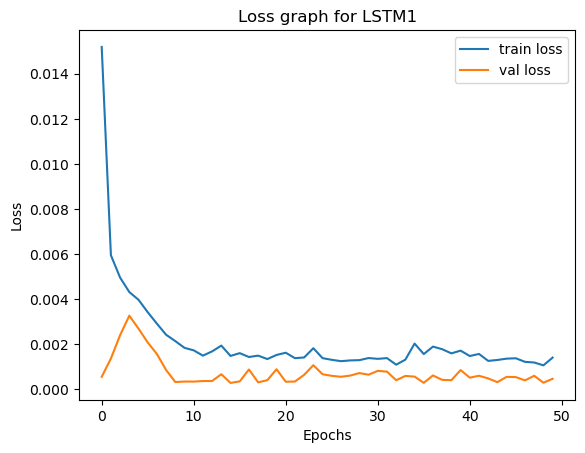

In [20]:
#Plotting the models loss 
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss graph for LSTM1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


 # Loss Graph interpretation 
 both the training loss and validation loss fluctuate while training an LSTM, it generally suggests a few potential issues with the training process.

- Learning Rate Too High
- Inadequate Model Architecture
- Insufficient Epochs or Early Stopping

The model has been run many times over, this is the final run and it shows underfitting, more complexity will be added to the next model, LSTM with more layers 

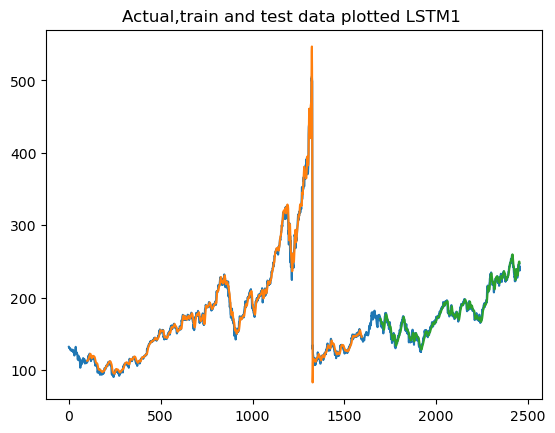

In [21]:
# plotting
# shift train predictions for plotting 
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
# shift test for predictions 
testPredictPlot =  np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back*2) +1: len(df1)-1,:] = test_predict

# Plotbaseline and predictions 
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Actual,train and test data plotted LSTM1 ')
plt.show()

In [22]:
print("df1 shape:", df1.shape)
print("train_predict shape:", train_predict.shape)
print("test_predict shape:", test_predict.shape)


df1 shape: (2456, 1)
train_predict shape: (1495, 1)
test_predict shape: (759, 1)


In [23]:
# calculate the last 100 days for prediction 
print(len(test_data))
X_input = test_data[760:].reshape(1,-1)
X_input.shape

860


(1, 100)

In [24]:
#convert it from an array to a lost for plotting 
temp_input = list(X_input)
temp_input = temp_input[0].tolist()

In [25]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        X_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,X_input))
        X_input=X_input.reshape(1,-1)
        X_input = X_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = stack_model.predict(X_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        X_input = X_input.reshape((1, n_steps,1))
        yhat = stack_model.predict(X_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.3657009]
101
1 day input [0.31593506 0.32574865 0.3348166  0.33361395 0.33003007 0.33904991
 0.3451834  0.34020445 0.34109441 0.34794949 0.35150932 0.35001804
 0.33775105 0.33729405 0.33931449 0.34410102 0.34475045 0.33616356
 0.32608539 0.31886951 0.31670475 0.32016837 0.31841251 0.3298617
 0.32861094 0.3220445  0.3220445  0.32418521 0.33164161 0.32389657
 0.33116055 0.33178593 0.33351774 0.3323632  0.33561034 0.34282622
 0.34809381 0.34778112 0.35355382 0.35898978 0.36634997 0.36721587
 0.36728803 0.36680698 0.37621167 0.37866506 0.37558629 0.37912207
 0.37953097 0.38653037 0.39239928 0.37933854 0.38352375 0.39482862
 0.39670475 0.40375225 0.40572459 0.39747444 0.38932051 0.38503909
 0.36923632 0.36805773 0.37200241 0.36529164 0.36647023 0.35239928
 0.34650631 0.34381239 0.35485268 0.33173782 0.33587492 0.31822008
 0.32108238 0.32067348 0.31855683 0.33558629 0.35579074 0.35843656
 0.35417919 0.35035478 0.3311365  0.34265785 0.3418641  0.34366807
 0.33022249 0.3302706  0.34222489 0

1 day output [[0.3628371]]
2 day input [0.32574865 0.3348166  0.33361395 0.33003007 0.33904991 0.3451834
 0.34020445 0.34109441 0.34794949 0.35150932 0.35001804 0.33775105
 0.33729405 0.33931449 0.34410102 0.34475045 0.33616356 0.32608539
 0.31886951 0.31670475 0.32016837 0.31841251 0.3298617  0.32861094
 0.3220445  0.3220445  0.32418521 0.33164161 0.32389657 0.33116055
 0.33178593 0.33351774 0.3323632  0.33561034 0.34282622 0.34809381
 0.34778112 0.35355382 0.35898978 0.36634997 0.36721587 0.36728803
 0.36680698 0.37621167 0.37866506 0.37558629 0.37912207 0.37953097
 0.38653037 0.39239928 0.37933854 0.38352375 0.39482862 0.39670475
 0.40375225 0.40572459 0.39747444 0.38932051 0.38503909 0.36923632
 0.36805773 0.37200241 0.36529164 0.36647023 0.35239928 0.34650631
 0.34381239 0.35485268 0.33173782 0.33587492 0.31822008 0.32108238
 0.32067348 0.31855683 0.33558629 0.35579074 0.35843656 0.35417919
 0.35035478 0.3311365  0.34265785 0.3418641  0.34366807 0.33022249
 0.3302706  0.34222489 0

In [26]:
#making variables for plotting, actual and predicted 
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

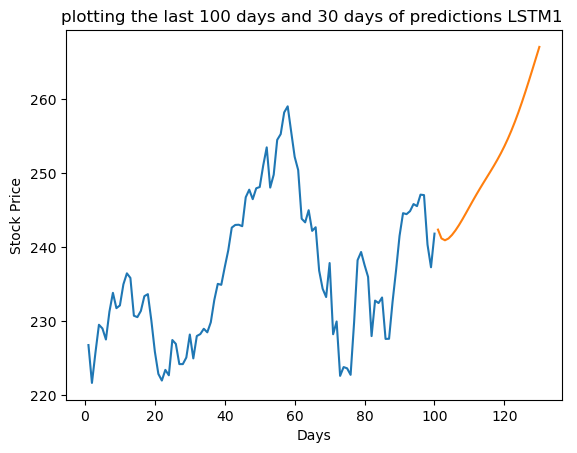

In [27]:
#plotting the df without the last 100 values and inserting the predicted values 
plt.plot(day_new,scaler.inverse_transform(df1[2356:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.title('plotting the last 100 days and 30 days of predictions LSTM1 ')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()

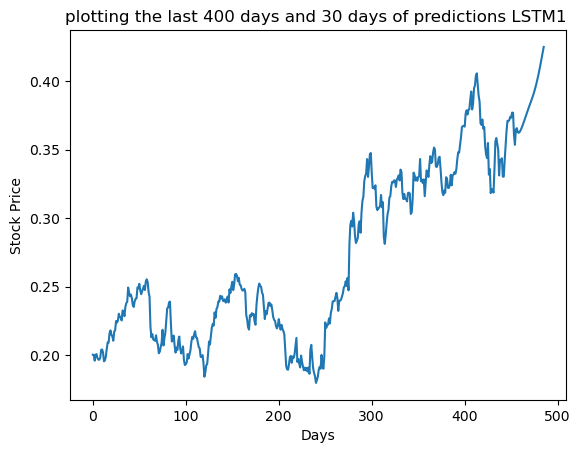

In [28]:
#plotting the predicted values at the end of the original df 
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[2000:])
plt.title('plotting the last 400 days and 30 days of predictions LSTM1 ')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()

Text(0, 0.5, 'Stock Price')

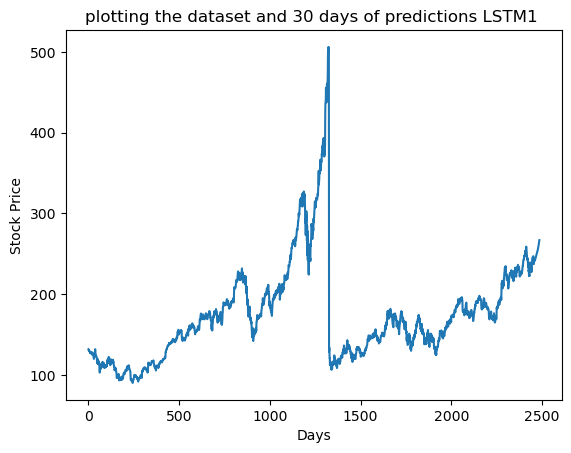

In [29]:
#
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)
plt.title('plotting the dataset and 30 days of predictions LSTM1 ')
plt.xlabel('Days')
plt.ylabel('Stock Price')

In [30]:
# Inverse scale the test_data (this will give us the original prices in the test data)
scaled_back_actual = scaler.inverse_transform(test_data[0:1])  # Scale back the first row

# First prediction (no need to scale back, as it's already in the original scale from the model)
first_prediction = test_predict[0]

# The date corresponding to the first actual value (index 1595 in the full dataset)
first_date = df.iloc[1595].name  # Use the full dataset index (1595) to find the date

# Print out the first actual value (scaled back), first prediction, and corresponding date
print(f"First actual value (scaled back): {scaled_back_actual[0]}")
print(f"First predicted value (index 0 of test_predict): {first_prediction}")
print(f"Date for the first comparison: {first_date}")

First actual value (scaled back): [145.37]
First predicted value (index 0 of test_predict): [170.85048]
Date for the first comparison: 1595


In [31]:

# Now, access the first and last prediction from the test data

# Example for the first trading day price (index 0)
print("The first trading day price prediction for 24/9/2021 for LSTM1 is: ", test_predict[0])

# The real first trading day price from the test_data (index 0)
print("The real first trading day price for 24/9/2021 for LSTM1 is: ", scaler.inverse_transform(test_data[0:1])[0])

# Example for the last trading day price (index 20)
print("The last trading day price prediction for 24/9/2021 for LSTM1 is: ", test_predict[20])

# The real last trading day price from the test_data (index 20)
print("The real last trading day price for 24/9/2021 for LSTM1 is: ", scaler.inverse_transform(test_data[20:21])[0])

The first trading day price prediction for 24/9/2021 for LSTM1 is:  [170.85048]
The real first trading day price for 24/9/2021 for LSTM1 is:  [145.37]
The last trading day price prediction for 24/9/2021 for LSTM1 is:  [156.03009]
The real last trading day price for 24/9/2021 for LSTM1 is:  [148.64]


In [32]:
print(test_predict[0])

[170.85048]


In [33]:
print(test_data[time_step])

[0.18891161]
